## MASTER IASD 2019-2020

### Author: KLOUVI Kodjo (kodjo.klouvi@gmail.com)

# Lab Assignment

In this lab assignment, you will improve your skills in scraping data from web pages, organizing the data in a desired format. To do so, we will use data that is provided by the Indeed company via their web pages.


You task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

Warning: I am using Python 3 for this lab assignment. If you are using Python 2, then some libraries may need to be changed., e.g., urllib -> urlib2.

In [1]:
import urllib.request
import urllib.error
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [2]:
# Fixed url for job postings containing data scientist
url = 'https://www.indeed.fr/jobs?q=data+scientist&l=%C3%8Ele-de-France'
# read the website
source = urllib.request.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

**Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

**Response 1:**

* Il s'agit d'un site de recherche d'emplois en ligne. Plus précisement, il s'agit de l'URL d'une page qui présente les résultats des offres d'emplois de _Data Scientist_ en Île-de-France.
* Le "`?`" est un token (marqueur) spécial qui permet d'indiquer le début des filtres (QUERY STRING) dans une URL. Les filtres sont constitués de paires de clé/valeur séparés par le signe "=".
* Le "`&`" est un token spécial qui permet de concatener plusieurs filtres.
* Le "`job title`" est défini dans la balise `<h2 class="title"></h2>`
* Le "`company name`" est défini dans la balise `<span class="company"></span>`
* Le "`job location`" est défini dans la balise `<div class="location accessible-contrast-color-location"></div>`

In [3]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCountPages').contents[0]
job_count_string = job_count_string.split()[-2]
print(("Search yielded %s hits." % (job_count_string)))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], list(range(len(job_count_digits))))])

print(job_count)

Search yielded 847 hits.
847


**Question 2**:
* What does the "find(id = 'searchCountPages')" in the first line mean?
* What does the second line do?


**Response 2:**

* `find(id = 'searchCountPages')`: permet de renvoyer l'élément DOM HTML de la page ayant pour identifiant (attribut id) `searchCountPages`. Cet élément dans l'exemple-ci contient le numéro de la page et le nombre total d'emplois trouvés.
* La deuxième ligne découpe `job_count_string` en plusieurs éléments séparés par des espaces et renvoie l'avant dernier élément (ici le nombre total d'emplois trouvés).

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page

**Response 3**

Ci-dessous le code qui renvoie l'élément _Salary Estimate_ (en français `Salaire estimé`):

In [4]:
# search for the Salary Estimate object on the page
salary_estimate_container = bs_tree.find(id = 'rb_Salary Estimate').select('span:nth-of-type(1)')[0]
print('Salary Estimate (container):', salary_estimate_container)

# Salary Estimate label
salary_estimate_label = salary_estimate_container.contents[0]
print('\nSalary Estimate (label):', salary_estimate_label)

Salary Estimate (container): <span aria-level="3" class="ws_bold" role="heading">
Salaire estimé</span>

Salary Estimate (label): 
Salaire estimé


The following piece of code allows you to find the links to all the job ads on the page.

In [6]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com/rc/clk?jk='
job_links = []
for i in range(2): #range(num_pages): #do range(num_pages) if you want them all
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')

    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    
    # go after each link
    for id in job_ids:
        if (id != None):
            job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)

print("We found a lot of jobs: ", len(job_links))

We found a lot of jobs:  34


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`



**Response 4:**

**Note:** _In the French version of Indeed website (indeed.fr) the number of jobs per page seems to be ~15. Potentially this number depends on the user browser's size or settings_.

* le paramètre `url` est ainsi défini pour pouvoir changer de page à chaque itération. En effet `start=str(i*10)` permet d'indiquer le numéro du premier job à afficher sur la page. Lorsque `i=3` on atterrit sur la quatrième page.
* La commande `bs_tree.find(id = 'resultsCol')` permet de récupérer l'objet qui a pour identifiant `resultsCol` c'est-à-dire celui qui contient l'ensemble des jobs affichés sur la page courantes.
* La commande `''.join(jp.get('class'))` échoue (chez moi) car `jp` n'est pas itérable (list, array, etc.).
* `job_links` contient les URLs (liens) des descriptifs détails des jobs. Chaque URL a un filtre (query string) de la forme `jk=xxx` où xxx est l'identifiant (id) du job à affichier.

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs



**Response 5:**

Ci-dessous le code qui recherche les 200 premiers jobs de data science.  
Etant donné que le nombre de jobs par pages n'est pas fixe, nous ne pouvons pas nous y fier pour calculer le nombre total de pages à parcourir.  
Nous allons juste parcourir la liste total des jobs jusqu'à obtenir 200.  


In [8]:
# The website is only listing 10 results per page, (not true in the French version)
# so we need to scrape them page after page
max_job_count = min(200, job_count) # we limit here the number of jobs to 200 (max)
num_pages = int(np.ceil(max_job_count/10.0)) # The number of jobs per page is not fixed. So we cannot compute precisely the number of pages

base_url = 'http://www.indeed.com'
data_scientist_job_links = []
for i in range(num_pages):
    url = 'https://www.indeed.fr/emplois?q=data+scientist&l=%C3%8Ele-de-France&start=' + str(i*10)
    html_page = urllib.request.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')

    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if str(jp.get('class')).find('row result')]
    
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # Just add the number of links until we reach 200 jobs
    # go after each link
    for id in job_ids:
        if (id != None):
            if len(data_scientist_job_links) < 200:
                data_scientist_job_links.append(base_url + '/rc/clk?jk=' + id)
            else:
                break;
                
    if len(data_scientist_job_links) == 200: # we stop the loop once we hit 200 jobs
        break;

    time.sleep(1)

print("We found a lot of data scientist jobs: ", len(data_scientist_job_links))

We found a lot of data scientist jobs:  200


The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

In [9]:
skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue
    try:
        html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters

        for key in list(skill_set.keys()):
            if key in html_text:  
                skill_set[key] +=1

        if counter % 5 == 0:
            print(len(job_links) - counter)
            print(skill_set)
    except:
        pass
            
print(skill_set)

{'hadoop': 0, 'spark': 0, 'python': 0}


**Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?


**Response 6:**
* `re.sub()` remplace dans le contenu de la page (courante) les caractères matchant l'expression régulière `[^a-z.+3]` par des espaces.
* `[^a-z.+3]` est une expression régulière désignant les caractères qui ne pas lettres minuscules, `.`, `+` et `3`.
* `skill_set` contient le nombre d'occurrences trouvées pour chacun des mots-clés (hadoop, spark, python) sur les pages (fournies par job_links).


The following piece of code plots the counts of different skills in the processed ads.

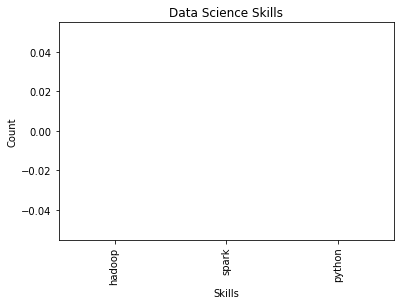

In [10]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

**Response 7:**

Nous remplaçons dans le code ci-dessous `job_links` par `data_scientist_job_links`

In [13]:
ds_skill_set = {'hadoop':0, 'spark':0, 'python':0}
counter = 0
for link in data_scientist_job_links[:50]: # we take only the 50th items
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        continue
    except urllib.error.URLError:
        continue
    except socket.error as error:
        print("Connection closed")
        continue

    try:
        html_text = re.sub("[^a-z.+3]"," ", html_page.decode('utf-8').lower()) # replace all but the listed characters


        for key in list(ds_skill_set.keys()):
            if key in html_text:  
                ds_skill_set[key] +=1

        if counter % 5 == 0:
            print(counter, '/', len(data_scientist_job_links))
            print(ds_skill_set)
    except:
        pass
        
print('data science skill set', ds_skill_set)

5 / 200
{'hadoop': 2, 'spark': 2, 'python': 4}
10 / 200
{'hadoop': 4, 'spark': 3, 'python': 9}
15 / 200
{'hadoop': 5, 'spark': 3, 'python': 14}
20 / 200
{'hadoop': 8, 'spark': 5, 'python': 18}
25 / 200
{'hadoop': 8, 'spark': 6, 'python': 22}
30 / 200
{'hadoop': 10, 'spark': 7, 'python': 27}
35 / 200
{'hadoop': 13, 'spark': 9, 'python': 32}
45 / 200
{'hadoop': 16, 'spark': 12, 'python': 40}
50 / 200
{'hadoop': 16, 'spark': 12, 'python': 43}
data science skill set {'hadoop': 16, 'spark': 12, 'python': 43}


## Data analysis of the housing market in the Paris area 

**(This exercise is optional)**

In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills of the jobs in Ile de France. In the second part of this lab, your task will be to create a pandas 'DataFrame' object containing information about the flats/houses that are available for rent in the paris area. For each offer, you will have to create columns such as: 
- Location
- Surface
- Number of rooms
- ...

To do so, we will be using seloger.com. Unlike the first part, where you were provided with snippets of codes that help you get familiarized with Web Scrapping skills, in this part you are left on your own to figure out how to do so. You can reduce your search to a specific area of paris, e.g., Paris 9, and for specific range of rent [700 euros,800 euros].

https://www.seloger.com/list.htm?projects=1&types=1,2&places=[{div:2238}]&price=700/800&enterprise=0&qsVersion=1.0

Note: I obtained the above URL by simply using the web page as a human via a browser, and specifying the criteria I needed to via the web form provided by seloger.com


## Exploration et analyse du marché immobilier à Paris

Note: Le site `seloger.com` cité en référence dans l'énoncé de ce projet bloque le scraping par une protection (captcha). Nous allons donc nous rabattre sur le site `avendrealouer.fr` (https://www.avendrealouer.fr/).

## 1. Importation des bibliothèques
Nous commençons par importer les bibliothèques

In [14]:
# start importing some useful libs
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

## 2. Fonction d'utilité
La fonction ci-dessous `to_int()` permet de convertir un `string` en entier en enlevant tout ce qui n'est pas un entier. 

In [15]:
# convert string into integer (remove non-number characters)
def to_int(str):
    str_digits = [int(d) for d in str if d.isdigit()]
    return np.sum([digit*(10**exponent) for digit, exponent in 
                        zip(str_digits[::-1], list(range(len(str_digits))))])

## 3. La recherche
Pour l'analyse nous allons utiliser un lien de recherche obtenu manuellement (`web_link`).  
Nous cherchons ici des biens à louer à Paris respectant les critères ci-dessous.

In [16]:
# we set here the research filters
rooms = ['1', '2', '3', '4', '5'] # number of rooms
min_surface = '35' # minimum surface
max_price = '1800' # maximum price


# set the link we'll be working on the following criteria
web_link = 'https://www.avendrealouer.fr/recherche.html?pageIndex=1&sortPropertyName=Price&sortDirection=Descending&searchTypeID=2&typeGroupCategoryID=6&localityIds=3-75&typeGroupIds=47&maximumPrice=' + max_price + '&minimumSurface=' + min_surface + '&roomComfortIds=' + ','.join(rooms) + '&pageIndex='


## 4. Nombre total de pages
Nous commençons par récupérer le nombre total de pages pour pouvoir parcourir toutes les pages renvoyées en résultat.

In [17]:
# read the number of pages
res = requests.get(web_link)
soup = BeautifulSoup(res.content, 'lxml')

# get the pagination block
pagination = soup.find('ul', {'class' : 'pagination'})

# get list of pages
pages = pagination.findAll('li')

# get the last page (last 3rd element)
last_page = int(pages[-3].getText())

print('total number of pages:', last_page)

total number of pages: 21


## 5. Récupération des annonces
Nous allons maintenant parcour chaque page afin de récupérer les informations sur chaque annonce.

In [18]:

# list of ads to transform into pandas dataframe. The ads properties will stored into dictionary
ads_list = []

print('start fetching real estate data...')
# loop through result's pages
for i in range(last_page):
    page = str(i+1)
    
    if i%5 == 0 or i == last_page-1:
        print('processing page', page, '/', last_page, '...')
    
    web_link_page = web_link + page
    # download webpage content
    res = requests.get(web_link_page)

    # read and convert the content into bs object
    soup = BeautifulSoup(res.content, 'lxml')


    # retieve the list of HTML ojects that contain the ads properties
    ads_dom_list = soup.findAll('a', {'class' : 'linkCtnr linkToFd'})


    # loop over the objects and perform some conversions
    for ads in ads_dom_list:
        try:
            # read the id of the ads
            id_string = ads.find('span', {'class':'favorite'})['data-id']

            # get the price
            price_string = ads.findAll('span', {'class':'price'})[0].getText()
            price_string = re.sub('€\r\n.*', '', price_string)
            price = to_int(price_string)

            # get the house location
            zip_code = ads.findAll('span', {'class':'loca'})[0].getText()
            m = re.search('.*\((.*)\).*', zip_code)
            zip_code = int(m.group(1))
            district = int(m.group(1)[-2:])
                
            surface, rooms = 0, 0
            # get the number of rooms
            rooms_object = ads.findAll('li')[1].getText()
            m = re.search('.*([0-9]+).*', rooms_object)
            if m:
                rooms = int(m.group(1))

            # get the surface of the house
            surface_object = ads.findAll('li')[2].getText()
            m = re.search('.*(^\d+).*', surface_object)
            if m:
                surface = int(m.group(1))

            # push the current ads properties into the list (via a dictionary)
            d = {'id':int(id_string), 'location':zip_code, 'district':district, 'surface':surface, 'rooms':rooms, 'price':price}
            ads_list.append(d)
            # print(d)
        except Valu:
            # skip unexpected errors
            print("Unexpected error:", sys.exc_info()[0])
            # print(ads)
            pass

print('done')
print('total records:', len(ads_list))

start fetching real estate data...
processing page 1 / 21 ...
processing page 6 / 21 ...
processing page 11 / 21 ...
processing page 16 / 21 ...
processing page 21 / 21 ...
done
total records: 525


## 6. Création de la DataFrame

In [19]:
# convert the ads list into pandas dataframe
df = pd.DataFrame(ads_list)    

pd.set_option('display.max_rows', None)

print('Real estate data crawled from avendrealouer.fr\n')
print(df.shape[0], 'data have been retrieved.\n\n')

print(df)

Real estate data crawled from avendrealouer.fr

525 data have been retrieved.


           id  location  district  surface  rooms  price
0    35249046     75004         4       37      2   1800
1    35252043     75004         4       43      1   1800
2    35125529     75017        17       35      1   1800
3    35105603     75020        20       62      2   1800
4    35149561     75008         8       40      1   1800
5    34898042     75005         5       42      2   1800
6    33426029     75006         6       52      2   1800
7    35253657     75008         8       50      2   1800
8    35606084     75008         8       60      3   1800
9    35480398     75116        16       47      2   1800
10   34237356     75001         1       40      2   1800
11   35499191     75010        10       60      3   1795
12   30560356     75016        16       51      3   1792
13   35366275     75012        12       53      2   1790
14   35658499     75010        10       43      4   1790
15   329

## 6. Features Extraction

Dans cette section nous allons appliquer quelques transformations aux features (`location`, `surface`,  `rooms`).  


### Découpage de Paris en secteurs géographiques
Tout d'abord nous allons sectoriser Paris en 5 zones géographiques que nous allons appeler `geoloc`:
* centre (1, 2, 3, 4) : CE
* nord-ouest (8, 9, 17) : NO
* nord-est (10, 18, 19, 20) : NE
* sud-est (5, 11, 12, 13) : SE
* sud-oeust (6, 7, 14, 15, 16) : SO

In [20]:
# split Paris into 5 zones grouped by district numbers (location)
zones = {'CE':[1, 2, 3, 4], 'NO':[8, 9, 17], 'NE':[10, 18, 19, 20], 'SE':[5, 11, 12, 13], 'SO':[6, 7, 14, 15, 16]}
zones_f = {}
for k in zones:
    for v in zones[k]:
        zones_f[v] = k

# create new feature from district numbers (locations)
df['geoloc'] = df.apply(lambda row: zones_f[row.district], axis=1)

#### Prix au mètre carré
Il est plus pertinent de baser l'anaylse sur le prix au carré qui donne une moyenne plutôt que sur le prix lui-même qui peut être sujet à de fortes variations.  
Pour ce faire nous allons introduire une autre variable `ppms` (price per meter square).

In [21]:
# compute price per meter square
df['ppms'] = df.apply(lambda row: int(row.price/row.surface), axis=1)

In [22]:
df.describe()

,id,location,district,surface,rooms,price,ppms
count,5.250000e+02,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,3.440206e+07,75015.017143,12.350476,47.049524,2.163810,1550.725714,33.108571
std,2.012348e+06,17.467464,5.055704,9.026965,0.662393,258.533055,6.058369
min,2.008730e+07,75001.000000,1.000000,35.000000,1.000000,1060.000000,20.000000
25%,3.391682e+07,75008.000000,8.000000,40.000000,2.000000,1300.000000,29.000000
50%,3.524810e+07,75013.000000,13.000000,45.000000,2.000000,1760.000000,32.000000
75%,3.548040e+07,75017.000000,17.000000,53.000000,3.000000,1795.000000,36.000000
max,3.567229e+07,75116.000000,20.000000,66.000000,4.000000,1800.000000,51.000000


In [23]:
print(df)

           id  location  district  surface  rooms  price geoloc  ppms
0    35249046     75004         4       37      2   1800     CE    48
1    35252043     75004         4       43      1   1800     CE    41
2    35125529     75017        17       35      1   1800     NO    51
3    35105603     75020        20       62      2   1800     NE    29
4    35149561     75008         8       40      1   1800     NO    45
5    34898042     75005         5       42      2   1800     SE    42
6    33426029     75006         6       52      2   1800     SO    34
7    35253657     75008         8       50      2   1800     NO    36
8    35606084     75008         8       60      3   1800     NO    30
9    35480398     75116        16       47      2   1800     SO    38
10   34237356     75001         1       40      2   1800     CE    45
11   35499191     75010        10       60      3   1795     NE    29
12   30560356     75016        16       51      3   1792     SO    35
13   35366275     75

## 7. Modélisation
Nous allons maintenant inférer les prix au mètre carré (`ppms`) de location des appartements (à Paris) en utilisant un modèle de regression `Random Forest` et en cosidérant comme features `district`,`geoloc`, `surface` et `rooms`.  

### One-Hot Encoding

In [24]:
# the model target column name
target_name = 'ppms'

# apply One-Hot-Encoding to the features (specificly to geoloc)
df2 = df[['district', 'geoloc', 'rooms', 'surface', target_name]]
df2 = pd.get_dummies(df2)

In [25]:
print(df2.head(20))

    district  rooms  surface  ppms  geoloc_CE  geoloc_NE  geoloc_NO  \
0          4      2       37    48          1          0          0   
1          4      1       43    41          1          0          0   
2         17      1       35    51          0          0          1   
3         20      2       62    29          0          1          0   
4          8      1       40    45          0          0          1   
5          5      2       42    42          0          0          0   
6          6      2       52    34          0          0          0   
7          8      2       50    36          0          0          1   
8          8      3       60    30          0          0          1   
9         16      2       47    38          0          0          0   
10         1      2       40    45          1          0          0   
11        10      3       60    29          0          1          0   
12        16      3       51    35          0          0          0   
13    

### Split Data into Features and Targets

Nous avons besoin d'isoler le label (`ppms`) et les features (`geoloc`, `surface`, `rooms`).  
Les features seront ensuite converties en Numpy Array (type attendu par le modèle).

In [26]:
# Labels are the values we want to predict (price)
labels = np.array(df2[target_name])

# Remove the labels from the features
# axis 1 refers to the columns
features= df2.drop(target_name, axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


### Training and Testing Sets

In [27]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Import the MSE
from sklearn.metrics import mean_squared_error
# Import accuracy engine
from sklearn.metrics import accuracy_score

In [28]:

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (420, 8)
Training Labels Shape: (420,)
Testing Features Shape: (105, 8)
Testing Labels Shape: (105,)


#### Entraîner le modèle (sur les données d'entraînement)

In [29]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

#### Faire une prédiction sur les données de test

In [30]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
mse = mean_squared_error(test_labels, predictions, squared=False)
mse = round(mse, 2)

# Print out the mean absolute error (mae)
print('MSE:', mse, '€/m2')
print('Conclusion: notre modèle s`est trompé globalement de +/-', mse, '€ sur le prix au m² à Paris!')


MSE: 1.71 €/m2
Conclusion: notre modèle s`est trompé globalement de +/- 1.71 € sur le prix au m² à Paris!


## Conlusion

Notre modèle est capable de prédire le prix de location des appartements à Paris à partir de la surface, du nombre de pièce et sa situation géographique.  
Pour cela, le modèle détermine le prix du mètre carré (pour la catégorie du bien) avec une marge d'erreur (calculée ci-dessus) et il suffira de multiplier cette valeur par la surface pour déduire le prix.

### Deliverable: the modified .ipynb file that contains the answers to the questions